In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

Alternative for Platinum

# **1. Alternative Catalyst**

In [2]:
data = pd.read_excel("/content/Alternative Catalyst.xlsx")

In [3]:
data.head()

,Electrocatalysts,Electrolytes,Current Density,Tafel slope,Overpotential,Structure
0,50% PANI/ZIF-67,1 M KOH,10,57,350,NaN
1,AB&CTGU-5 (1:4),0.5 M H2SO4,10,45,44,NaN
2,Co/N-carbon,1 M KOH,10,NaN,103,NaN
3,Co@N-CNTs@rGO,1 M KOH,10,55,108,NaN
4,Co@N-CNTs@rGO,0.5 M H2SO4,10,52,87,NaN


In [4]:
data.shape

(514, 6)

In [5]:
data.isnull().sum()

Electrocatalysts    106
Electrolytes        156
Current Density       0
Tafel slope          49
Overpotential        87
Structure           297
dtype: int64

## **a. Handling Missing Values**

how many rows meet the conditions to use the Tafel equation?

In [6]:
# Convert the columns to numeric (errors='coerce' will convert non-numeric values to NaN)
data['Tafel slope'] = pd.to_numeric(data['Tafel slope'], errors='coerce')
data['Overpotential'] = pd.to_numeric(data['Overpotential'], errors='coerce')

# Determine the rows where the Tafel equation can be applied
tafel_applicable_rows = data[
    (~data['Current Density'].isnull()) &
    ((~data['Tafel slope'].isnull() & data['Overpotential'].isnull()) |
     (data['Tafel slope'].isnull() & ~data['Overpotential'].isnull()))
]

tafel_applicable_rows_count = len(tafel_applicable_rows)

tafel_applicable_rows_count


140

### **Type Conversions**

- converting current density from mA/cm2 to A/m2

In [7]:
data['Current Density'] *= 100

- converting Overpotential from mV to V

In [8]:
data['Overpotential'] /= 1000

- converting Tafel slope from mV/dec to V/dec

In [9]:
data['Tafel slope'] /= 1000

Applying Tafel equation to compute the missing values for the Tafel slope and Overpotential in the applicable rows.

In [10]:
import numpy as np

# Assumed value for exchange current density (i_0)
i_0 = 10**-6

def compute_missing_values(row):
    """Compute missing values using the Tafel equation."""
    if pd.isnull(row['Tafel slope']) and not pd.isnull(row['Overpotential']):
        # Calculate Tafel slope (A) using the equation
        A = np.abs(row['Overpotential'] / np.log10(row['Current Density'] / i_0))
        row['Tafel slope'] = A
    elif not pd.isnull(row['Tafel slope']) and pd.isnull(row['Overpotential']):
        # Calculate Overpotential (η) using the equation
        eta = row['Tafel slope'] * np.log10(row['Current Density'] / i_0)
        row['Overpotential'] = eta
    return row

# Apply the function to rows where the Tafel equation can be used
data = data.apply(lambda row: compute_missing_values(row) if row.name in tafel_applicable_rows.index else row, axis=1)

# Check the first few rows again
data.head()

,Electrocatalysts,Electrolytes,Current Density,Tafel slope,Overpotential,Structure
0,50% PANI/ZIF-67,1 M KOH,1000,0.057000,0.350,NaN
1,AB&CTGU-5 (1:4),0.5 M H2SO4,1000,0.045000,0.044,NaN
2,Co/N-carbon,1 M KOH,1000,0.011444,0.103,NaN
3,Co@N-CNTs@rGO,1 M KOH,1000,0.055000,0.108,NaN
4,Co@N-CNTs@rGO,0.5 M H2SO4,1000,0.052000,0.087,NaN


for rows where the Tafel equation couldn't be used and for other columns with missing values (like 'Structure'), we'll employ the Random Forest algorithm.

**1. handle the missing values in the categorical columns by replacing them with the mode of each respective column.**

In [11]:
# Replace missing values in categorical columns with the mode
for column in ['Electrocatalysts', 'Electrolytes', 'Structure']:
  if column == 'Electrocatalysts':
    data[column].ffill()
    continue
  mode_value = data[column].mode()[0]
  data[column].fillna(mode_value, inplace=True)

# Check for remaining missing values in the dataset
remaining_missing_values = data.isnull().sum()

remaining_missing_values

Electrocatalysts    106
Electrolytes          0
Current Density       0
Tafel slope          22
Overpotential        22
Structure             0
dtype: int64

 one-hot encoding for the categorical columns.

In [12]:
# One-hot encode the categorical columns
data_encoded = pd.get_dummies(data, columns=['Electrocatalysts', 'Electrolytes', 'Structure'])

# Check the shape and first few rows of the encoded dataset
data_encoded_shape = data_encoded.shape
data_encoded.head()

,Current Density,Tafel slope,Overpotential,Electrocatalysts_(Co)-doped 1T-MoS2,Electrocatalysts_(PA-CoP),Electrocatalysts_(PA-MoP),Electrocatalysts_(porous carbon),Electrocatalysts_10 wt% Ir/C,Electrocatalysts_1D Ni2P @graphitized carbon,Electrocatalysts_1T-MoS2/CoS2,...,Structure_nanodots,Structure_nanoflower,Structure_nanograin,Structure_nanoparticles,Structure_nanoplatelet,Structure_nanoplates,Structure_nanosheet/carbon cloth,Structure_nanosheets,Structure_nanotubes,Structure_nanowires
0,1000,0.057000,0.350,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000,0.045000,0.044,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000,0.011444,0.103,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000,0.055000,0.108,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000,0.052000,0.087,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Separate the data into training and prediction sets for 'Tafel slope'
train_data_tafel = data_encoded.dropna(subset=['Tafel slope'])
predict_data_tafel = data_encoded[data_encoded['Tafel slope'].isnull()]

# Define the features and target for training
X_train_tafel = train_data_tafel.drop(columns=['Tafel slope', 'Overpotential'])
y_train_tafel = train_data_tafel['Tafel slope']

# Train a Random Forest regressor for 'Tafel slope'
rf_tafel = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tafel.fit(X_train_tafel, y_train_tafel)

# Predict the missing values for 'Tafel slope'
X_predict_tafel = predict_data_tafel.drop(columns=['Tafel slope', 'Overpotential'])
predicted_tafel_values = rf_tafel.predict(X_predict_tafel)

# Fill the missing values in the original dataset
data_encoded.loc[data_encoded['Tafel slope'].isnull(), 'Tafel slope'] = predicted_tafel_values

# Check if missing values remain for 'Tafel slope'
remaining_missing_tafel = data_encoded['Tafel slope'].isnull().sum()

remaining_missing_tafel

0

In [14]:
# Separate the data into training and prediction sets for 'Overpotential'
train_data_overpotential = data_encoded.dropna(subset=['Overpotential'])
predict_data_overpotential = data_encoded[data_encoded['Overpotential'].isnull()]

# Define the features and target for training
X_train_overpotential = train_data_overpotential.drop(columns=['Tafel slope', 'Overpotential'])
y_train_overpotential = train_data_overpotential['Overpotential']

# Train a Random Forest regressor for 'Overpotential'
rf_overpotential = RandomForestRegressor(n_estimators=100, random_state=42)
rf_overpotential.fit(X_train_overpotential, y_train_overpotential)

# Predict the missing values for 'Overpotential'
X_predict_overpotential = predict_data_overpotential.drop(columns=['Tafel slope', 'Overpotential'])
predicted_overpotential_values = rf_overpotential.predict(X_predict_overpotential)

# Fill the missing values in the original dataset
data_encoded.loc[data_encoded['Overpotential'].isnull(), 'Overpotential'] = predicted_overpotential_values

# Check if missing values remain for 'Overpotential'
remaining_missing_overpotential = data_encoded['Overpotential'].isnull().sum()

remaining_missing_overpotential


0

In [15]:
# Decoding the one-hot encoded data to revert categorical columns to their original form
decoded_data = data_encoded.copy()

# Extracting original columns from one-hot encoded data
decoded_data['Electrocatalysts'] = decoded_data.filter(like='Electrocatalysts_').idxmax(axis=1).str.replace('Electrocatalysts_', '')
decoded_data['Electrolytes'] = decoded_data.filter(like='Electrolytes_').idxmax(axis=1).str.replace('Electrolytes_', '')
decoded_data['Structure'] = decoded_data.filter(like='Structure_').idxmax(axis=1).str.replace('Structure_', '')

# Drop the one-hot encoded columns
columns_to_drop = decoded_data.columns[decoded_data.columns.str.contains('Electrocatalysts_|Electrolytes_|Structure_')]
decoded_data.drop(columns=columns_to_drop, inplace=True)

# Reorder columns to match the original structure
decoded_data = decoded_data[['Electrocatalysts', 'Electrolytes', 'Current Density', 'Tafel slope', 'Overpotential', 'Structure']]

In [16]:
decoded_data.head()

,Electrocatalysts,Electrolytes,Current Density,Tafel slope,Overpotential,Structure
0,50% PANI/ZIF-67,1 M KOH,1000,0.057000,0.350,Nanoparticle
1,AB&CTGU-5 (1:4),0.5 M H2SO4,1000,0.045000,0.044,Nanoparticle
2,Co/N-carbon,1 M KOH,1000,0.011444,0.103,Nanoparticle
3,Co@N-CNTs@rGO,1 M KOH,1000,0.055000,0.108,Nanoparticle
4,Co@N-CNTs@rGO,0.5 M H2SO4,1000,0.052000,0.087,Nanoparticle


**Labelling the dataset for deciding which is the best alterntaive for platinum**

To define the thresholds for the "best", "medium", and "bad" categories, we need to determine the cutoff values. One approach is to use the quantiles:

- "Best" alternatives: Electrolytes in the lowest 10% for both Tafel slope and Overpotential scores.
- "Worst" alternatives: Electrolytes in the highest 10% for both Tafel slope and Overpotential scores.
- Intermediate classes ("Excellent", "Good", "Average", "Below Average", "Poor") can be defined for the remaining 80%.

In [17]:
# Define the 5% thresholds for Tafel slope and Overpotential scores
tafel_5_threshold = decoded_data['Tafel slope'].quantile(0.05)
tafel_95_threshold = decoded_data['Tafel slope'].quantile(0.95)
overpotential_5_threshold = decoded_data['Overpotential'].quantile(0.05)
overpotential_95_threshold = decoded_data['Overpotential'].quantile(0.95)

def label_top_5_percent(row):
    """Label the electrocatalysts using the top 5% threshold."""
    if row['Tafel slope'] <= tafel_5_threshold and row['Overpotential'] <= overpotential_5_threshold:
        return 'Best'
    elif row['Tafel slope'] >= tafel_95_threshold and row['Overpotential'] >= overpotential_95_threshold:
        return 'Worst'
    elif tafel_5_threshold < row['Tafel slope'] <= decoded_data['Tafel slope'].quantile(0.20) or overpotential_5_threshold < row['Overpotential'] <= decoded_data['Overpotential'].quantile(0.20):
        return 'Excellent'
    elif tafel_5_threshold < row['Tafel slope'] <= decoded_data['Tafel slope'].quantile(0.40) or overpotential_5_threshold < row['Overpotential'] <= decoded_data['Overpotential'].quantile(0.40):
        return 'Good'
    elif tafel_95_threshold > row['Tafel slope'] >= decoded_data['Tafel slope'].quantile(0.60) or overpotential_95_threshold > row['Overpotential'] >= decoded_data['Overpotential'].quantile(0.60):
        return 'Below Average'
    elif tafel_95_threshold > row['Tafel slope'] >= decoded_data['Tafel slope'].quantile(0.80) or overpotential_95_threshold > row['Overpotential'] >= decoded_data['Overpotential'].quantile(0.80):
        return 'Poor'
    else:
        return 'Average'

# Apply the labeling function
decoded_data['Alternative_Label_Top_5'] = decoded_data.apply(label_top_5_percent, axis=1)

# Display the distribution of the new labels
top_5_label_distribution = decoded_data['Alternative_Label_Top_5'].value_counts()

top_5_label_distribution


Below Average    183
Excellent        147
Good             141
Average           30
Worst              7
Best               6
Name: Alternative_Label_Top_5, dtype: int64

In [18]:
decoded_data.head()

,Electrocatalysts,Electrolytes,Current Density,Tafel slope,Overpotential,Structure,Alternative_Label_Top_5
0,50% PANI/ZIF-67,1 M KOH,1000,0.057000,0.350,Nanoparticle,Below Average
1,AB&CTGU-5 (1:4),0.5 M H2SO4,1000,0.045000,0.044,Nanoparticle,Excellent
2,Co/N-carbon,1 M KOH,1000,0.011444,0.103,Nanoparticle,Good
3,Co@N-CNTs@rGO,1 M KOH,1000,0.055000,0.108,Nanoparticle,Good
4,Co@N-CNTs@rGO,0.5 M H2SO4,1000,0.052000,0.087,Nanoparticle,Excellent


## **b. Exploratory Data Analysis**

In [19]:
# Descriptive statistics for the numeric columns
descriptive_stats = decoded_data[['Tafel slope', 'Overpotential']].describe()

descriptive_stats

,Tafel slope,Overpotential
count,514.000000,514.000000
mean,0.061006,0.243621
std,0.026836,0.232725
min,0.009999,0.000000
25%,0.046175,0.098000
50%,0.056000,0.150000
75%,0.068375,0.330000
max,0.270000,2.430000


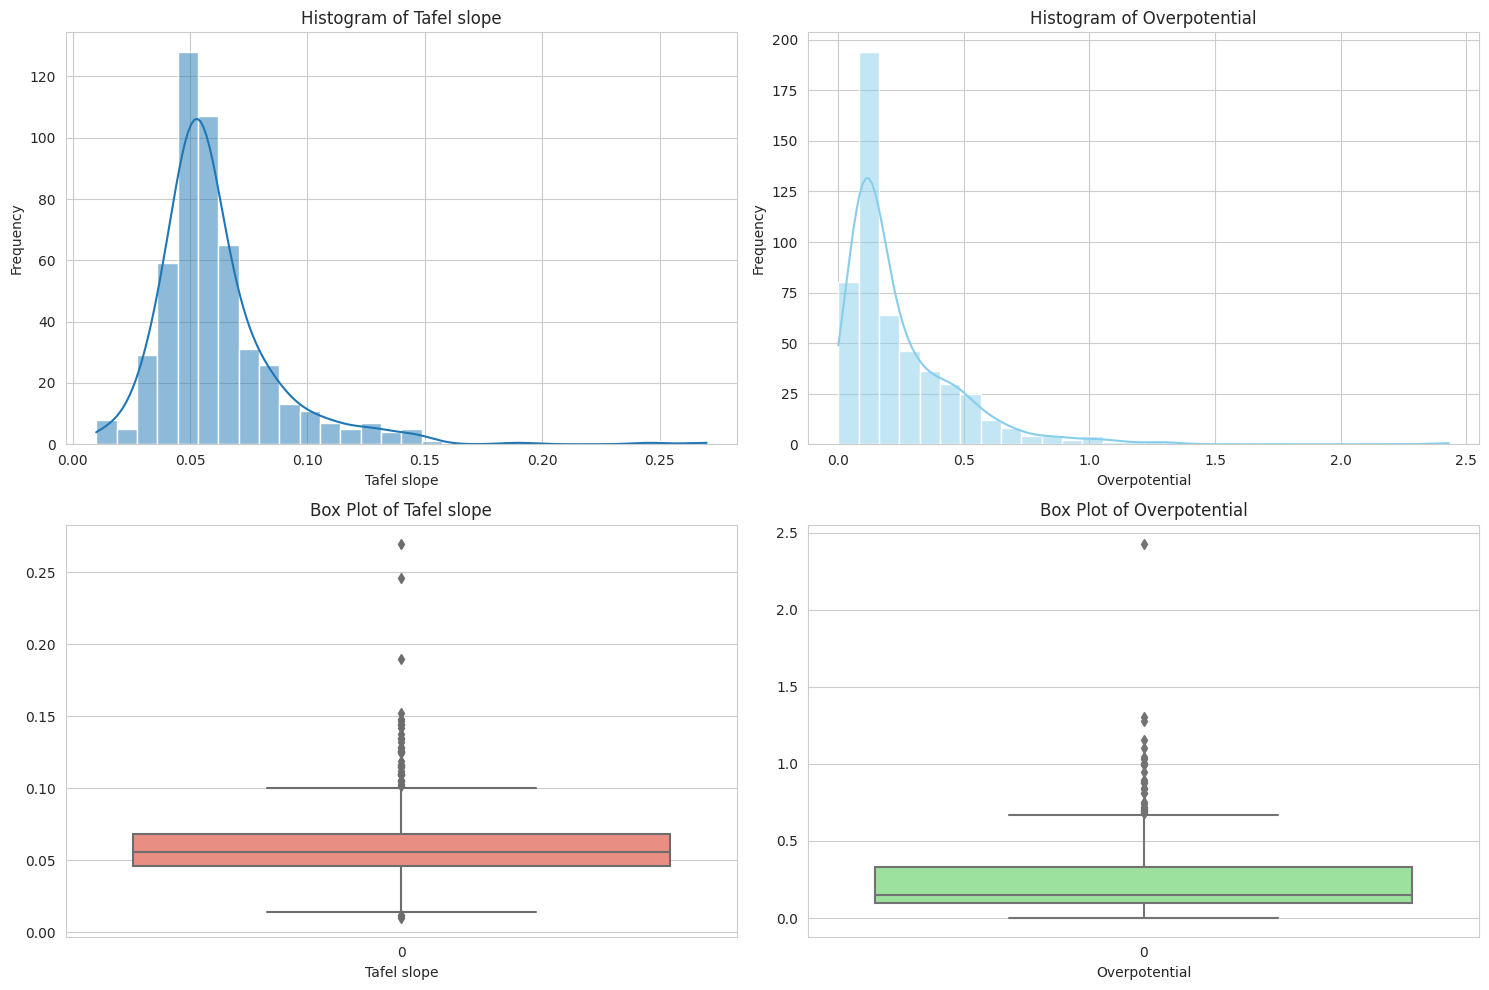

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for plots
sns.set_style("whitegrid")

# Initialize a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot the histogram for Tafel slope
sns.histplot(decoded_data['Tafel slope'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Tafel slope')
axes[0, 0].set_xlabel('Tafel slope')
axes[0, 0].set_ylabel('Frequency')

# Plot the histogram for Overpotential
sns.histplot(decoded_data['Overpotential'], bins=30, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Histogram of Overpotential')
axes[0, 1].set_xlabel('Overpotential')
axes[0, 1].set_ylabel('Frequency')

# Plot the box plot for Tafel slope
sns.boxplot(decoded_data['Tafel slope'], ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Box Plot of Tafel slope')
axes[1, 0].set_xlabel('Tafel slope')

# Plot the box plot for Overpotential
sns.boxplot(decoded_data['Overpotential'], ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Box Plot of Overpotential')
axes[1, 1].set_xlabel('Overpotential')

# Adjust the layout
plt.tight_layout()
plt.show()

Here are the visualizations for the 'Tafel slope' and 'Overpotential' columns:

1. **Histogram of Tafel slope:** Most of the values are clustered around 40 to 80, with a peak near 55. There are some values that extend beyond 150, indicating potential outliers.
2. **Histogram of Overpotential:** This column has a wider distribution, with a peak around 150. There are values that extend significantly beyond 1000, indicating potential outliers.
3. **Box Plot of Tafel slope:** The median is around 55, with the interquartile range (IQR) between approximately 48 and 69. There are some potential outliers beyond the upper whisker.
4. **Box Plot of Overpotential:** The median is around 157.5, with the IQR between approximately 98.25 and 294. Again, there are potential outliers beyond the upper whisker.

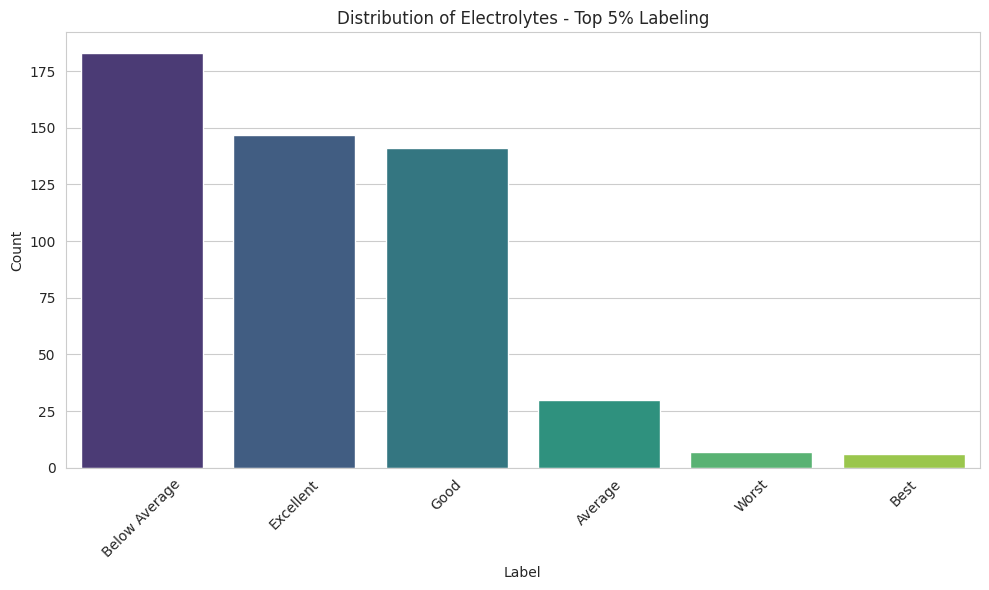

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set_style("whitegrid")

# Initialize a figure
plt.figure(figsize=(10, 6))

# Bar chart for Alternative_Label_Top_5
sns.countplot(data=decoded_data, x='Alternative_Label_Top_5', order=decoded_data['Alternative_Label_Top_5'].value_counts().index, palette="viridis")
plt.title('Distribution of Electrolytes - Top 5% Labeling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [22]:
decoded_data['Alternative_Label_Top_5'].value_counts()

Below Average    183
Excellent        147
Good             141
Average           30
Worst              7
Best               6
Name: Alternative_Label_Top_5, dtype: int64

In [23]:
decoded_data.to_csv("dataset.csv", index=False)

In [24]:
data = decoded_data.copy()

## **c. Building a Classification Model**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [26]:
#Surpressing warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

### **Label Encoding**

In [27]:
# Perform label encoding on the categorical columns
label_encoders = {}
for column in ['Electrocatalysts', 'Electrolytes', 'Structure']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

### **Train Test Split**

In [28]:
# Split the data into training and testing sets (70:30 ratio) with stratified sampling
X = data.drop(columns='Alternative_Label_Top_5')
y = data['Alternative_Label_Top_5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(X_train.shape, X_test.shape)

(359, 6) (155, 6)


### **Model Building**

1. Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier
4. Support Vector Machine (SVM)
5. Gradient Boosting Classifier

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [30]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [31]:
# Train the models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully!")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained successfully!
Decision Tree trained successfully!
Random Forest trained successfully!
Support Vector Machine trained successfully!
Gradient Boosting trained successfully!


### **Model Evaluation**

In [32]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [33]:
# Function to calculate multi-class ROC AUC score
def multi_class_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [34]:
# Create a dictionary to store the predictions for each model and their accuracy scores
predictions = {}
accuracy_scores = {}

# Predict the labels on the test data and compute accuracy for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    predictions[name] = y_pred

In [35]:
# Compute and display the performance metrics for each model
for name, y_pred in predictions.items():
    print("\n\n", name)
    print("Accuracy: ", accuracy_scores[name])
    print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
    print("ROC AUC Score:", multi_class_roc_auc_score(y_test, y_pred))
    print("Classification Report")
    print(classification_report(y_test, y_pred))



 Logistic Regression
Accuracy:  0.5096774193548387
F1 Score:  0.4305648810392644
ROC AUC Score: 0.5733559345272752
Classification Report
               precision    recall  f1-score   support

      Average       0.00      0.00      0.00         9
Below Average       0.52      0.84      0.64        55
         Best       0.00      0.00      0.00         2
    Excellent       0.57      0.09      0.16        44
         Good       0.49      0.67      0.57        43
        Worst       0.00      0.00      0.00         2

     accuracy                           0.51       155
    macro avg       0.26      0.27      0.23       155
 weighted avg       0.48      0.51      0.43       155



 Decision Tree
Accuracy:  0.9870967741935484
F1 Score:  0.9870967741935484
ROC AUC Score: 0.9878214796365481
Classification Report
               precision    recall  f1-score   support

      Average       0.89      0.89      0.89         9
Below Average       0.98      0.98      0.98        55
         

## **d. Displaying the best alternative catalysts**

**Top Best Catalysts**

In [40]:
label_order = ["Best", "Excellent", "Good", "Average", "Below Average", "Worst"]
label_mapping = {label: idx for idx, label in enumerate(label_order)}

# Sorting the data
sorted_data = decoded_data.sort_values(by=["Alternative_Label_Top_5", "Overpotential", "Tafel slope"],
                                       key=lambda col: col.map(label_mapping) if col.name == "Alternative_Label_Top_5" else col)

sorted_data.head(20)

,Electrocatalysts,Electrolytes,Current Density,Tafel slope,Overpotential,Structure,Alternative_Label_Top_5
26,IrCo@NC-500,0.5 M H2SO4,1000,0.0230,0.024,Nanoparticle,Best
43,RuCo@NC,1 M KOH,1000,0.0310,0.028,Nanoparticle,Best
44,Ru–MoO2,1 M KOH,1000,0.0310,0.029,Nanoparticle,Best
139,FeP,0.5 M H2SO4,1000,0.0290,0.034,Nanocrystal,Best
279,Rugae-like FeP/carbon cloth,0.5 M H2SO4,1000,0.0292,0.034,Nanoparticle,Best
250,CoP nanosheet/carbon cloth,0.5 M H2SO4,1000,0.0301,0.049,Nanoparticle,Best
430,Ni/NiO/CoSe2,0.5 M H2SO4,0,0.0390,0.030,Nanoparticle,Excellent
325,NiCoP/Ni foam,1.0 M KOH (HER),1000,0.0370,0.032,foam,Excellent
1,AB&CTGU-5 (1:4),0.5 M H2SO4,1000,0.0450,0.044,Nanoparticle,Excellent
251,(Co)-doped 1T-MoS2,1.0 M KOH (HER),1000,0.0426,0.048,Nanoparticle,Excellent


In [42]:
sorted_data[sorted_data['Alternative_Label_Top_5']=='Best']

,Electrocatalysts,Electrolytes,Current Density,Tafel slope,Overpotential,Structure,Alternative_Label_Top_5
26,IrCo@NC-500,0.5 M H2SO4,1000,0.0230,0.024,Nanoparticle,Best
43,RuCo@NC,1 M KOH,1000,0.0310,0.028,Nanoparticle,Best
44,Ru–MoO2,1 M KOH,1000,0.0310,0.029,Nanoparticle,Best
139,FeP,0.5 M H2SO4,1000,0.0290,0.034,Nanocrystal,Best
279,Rugae-like FeP/carbon cloth,0.5 M H2SO4,1000,0.0292,0.034,Nanoparticle,Best
250,CoP nanosheet/carbon cloth,0.5 M H2SO4,1000,0.0301,0.049,Nanoparticle,Best


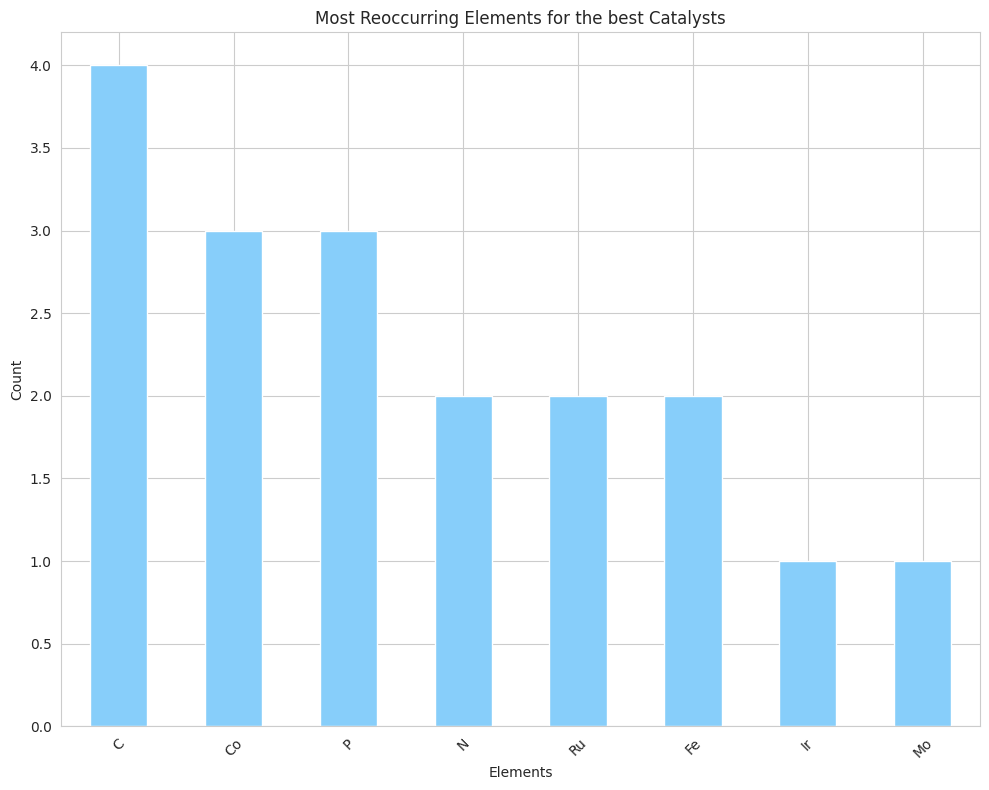

In [38]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Define provided electrocatalysts
provided_electrocatalysts = [
    'IrCo@NC-500', 'RuCo@NC', 'Ru–MoO2', 'FeP', 'FeP/C', 'CoP /C'
]

# Extract individual elements from the Electrocatalysts column
elements = []
for catalyst in provided_electrocatalysts:
    # Extracting potential element symbols using regex
    extracted_elements = re.findall(r'[A-Z][a-z]*', catalyst)
    elements.extend(extracted_elements)

# Filter out 'O' from the elements list
filtered_elements = [element for element in elements if element != 'O']
filtered_element_counts = pd.Series(filtered_elements).value_counts()

# Plot the most reoccurring elements without 'O'
plt.figure(figsize=(10, 8))
filtered_element_counts.plot(kind='bar', color='lightskyblue')
plt.title('Most Reoccurring Elements for the best Catalysts')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


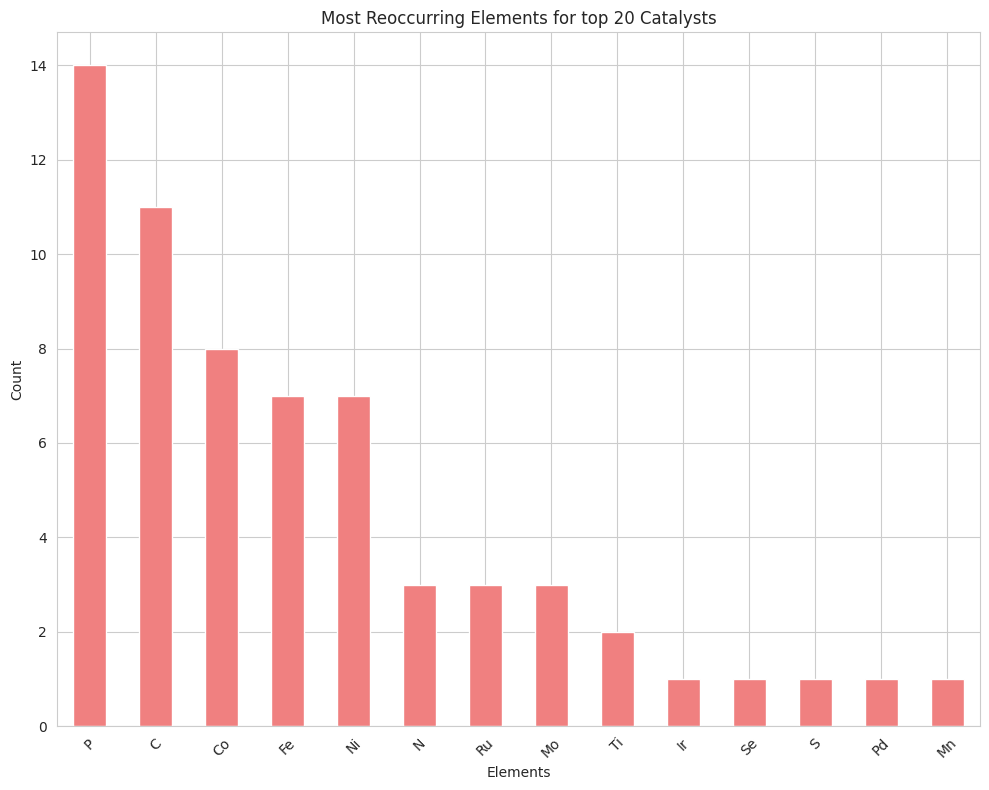

In [41]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Updated provided electrocatalysts
updated_electrocatalysts = [
    'IrCo@NC-500', 'RuCo@NC', 'Ru–MoO2', 'FeP', 'FeP/C', 'CoP /C', 'Ni/NiO/CoSe2', 'NiCoP/Ni',
    'Co/C', '(Co)-doped MoS2', 'NiRu@N–C', 'FeP/Ti', 'Pd–Mn3O4','MoP@PC', 'FeP@PC', 'FeP C',
    'FeP C', 'CoP', 'Ni2P-C@Ni', 'FeP Ti'
]

# Extract individual elements from the Electrocatalysts column
updated_elements = []
for catalyst in updated_electrocatalysts:
    # Extracting potential element symbols using regex
    extracted_elements = re.findall(r'[A-Z][a-z]*', catalyst)
    updated_elements.extend(extracted_elements)

# Filter out 'O' from the elements list
updated_filtered_elements = [element for element in updated_elements if element != 'O']
updated_filtered_element_counts = pd.Series(updated_filtered_elements).value_counts()

# Plot the most reoccurring elements without 'O' for the updated list
plt.figure(figsize=(10, 8))
updated_filtered_element_counts.plot(kind='bar', color='lightcoral')
plt.title('Most Reoccurring Elements for top 20 Catalysts')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
